# Name of the Student : Aagam Manish Shah

# USC ID Number : 8791018480

# 7.2 (Deep) CNNs for Image Colorization

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
from tensorflow import keras
from sklearn.cluster import KMeans
from skimage.color import rgb2gray
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [2]:
for module in keras, sklearn, tf:
  print("{} version is {}".format(module.__name__, module.__version__))

tensorflow.keras version is 2.3.0-tf
sklearn version is 0.22.2.post1
tensorflow version is 2.2.0


## (a) This assignment uses a convolutional neural network for image colorization which turns a grayscale image to a colored image. By converting an image to grayscale, we loose color information, so converting a grayscale image back to a colored version is not an easy job. We will use the CIFAR-10 dataset. Downolad the dataset from http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz.

In [3]:
from keras.datasets import cifar10
(X_train_total, y_train_total), (X_test_total, y_test_total) = cifar10.load_data()

Using TensorFlow backend.


170500096/170498071 [==============================] - 4s 0us/step


In [4]:
print("-----------------Before Extraction----------------")
print("Training Dataset: ", X_train_total.shape, y_train_total.shape)
print("Testing Dataset: ", X_test_total.shape, y_test_total.shape)

-----------------Before Extraction----------------
Training Dataset:  (50000, 32, 32, 3) (50000, 1)
Testing Dataset:  (10000, 32, 32, 3) (10000, 1)


## (b) From the train and test dataset, extract the class birds. We will focus on this class, which has 6000 members.

In [5]:
X_train_reshape = X_train_total.reshape(-1, 32*32*3)
y_train_reshape = y_train_total.reshape(-1)

X_test_reshape = X_test_total.reshape(-1, 32*32*3)
y_test_reshape = y_test_total.reshape(-1)

X_train = X_train_reshape[y_train_reshape == 2].reshape(-1, 32, 32, 3)
y_train = y_train_reshape[y_train_reshape == 2]

X_test = X_test_reshape[y_test_reshape == 2].reshape(-1, 32, 32, 3)
y_test = y_test_reshape[y_test_reshape == 2]

In [6]:
print("-----------------After Extraction-----------------")
print("Training Dataset: ", X_train.shape, y_train.shape)
print("Testing Dataset: ", X_test.shape, y_test.shape)

-----------------After Extraction-----------------
Training Dataset:  (5000, 32, 32, 3) (5000,)
Testing Dataset:  (1000, 32, 32, 3) (1000,)


## (c) Those 6000 images have 6000 x 32 x 32 pixels. Choose at least 10% of the pixels randomly. It is strongly recommended that you choose a large number or all of the pixels. You will have between P = 614400 and P = 6144000 pixels. Each pixel is an RGB vector with three elements.

Concatenated Data Set:  (6000, 32, 32, 3) (6000,)
-----------------Original Image-----------------


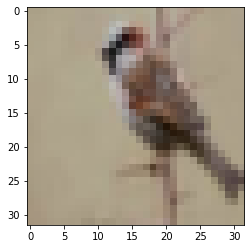

In [8]:
X_data = np.concatenate((X_train,X_test))
y_data = np.concatenate((y_train,y_test))

print("Concatenated Data Set: ", X_data.shape, y_data.shape)
print("-----------------Original Image-----------------")
plt.imshow(X_data[81])

## (d) Run k-means clustering on the P vectors using k = 4. The centers of the clusters will be your main colors. Convert the colored images to k-color images by converting each pixel's value to the closest main color in terms of Euclidean distance. These are the outputs of your network, whose each pixel falls in one of those k classes.

In [9]:
X_data_new = X_data.reshape(-1, 3)
k_means_clf = KMeans(n_clusters=4, random_state=2333, n_init=10).fit(X_data_new)
main_colors = k_means_clf.cluster_centers_
y_predict = k_means_clf.labels_

-----------------Converted Image-----------------


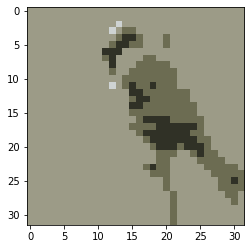

In [10]:
X_converted = np.array([main_colors[y_predict[i]] for i in range(len(X_data_new))], dtype=np.uint8).reshape(-1, 32, 32, 3)

print("-----------------Converted Image-----------------")
plt.imshow(X_converted[81])

-----------------Suggested PIC-----------------


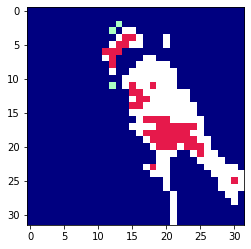

In [15]:
distinct_color = np.array([[0,0,128],[230,25,75],[170,255,195],[255,255,255]], dtype=np.uint8)
X_suggest = np.array([distinct_color[y_predict[i]] for i in range(len(X_data_new))], dtype=np.uint8).reshape(-1, 32, 32, 3)

print("-----------------Suggested Image-----------------")
plt.imshow(X_suggest[81])

## (e) Use any tool (e.g., openCV or scikit-learn) to obtain grayscale 32x32x1 images from the original 32 x 32 x 3 images. The grayscale images are inputs of your network.

-----------------Grayscale Image-----------------


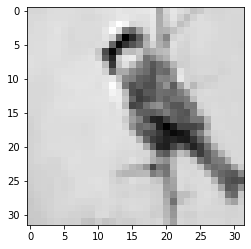

In [16]:
X_grayscale = np.array([rgb2gray(X_data[i]) for i in range(len(X_data))])
print("-----------------Grayscale Image-----------------")
plt.imshow(X_grayscale[81], cmap=plt.cm.gray)

## (f) Set up a deep convolutional neural network with two convolution layers (or more) and two (or more) MLP layers. Use 5 x 5 filters and a softmax output layer. Determine the number of filters, strides, and whether or not to use padding your- self. Use a minimum of one max pooling layer. Use a classification scheme, which means your output must determine one of the k = 4 color classes for each pixel in your grayscale image. Your input is a grayscale version of an image (32x32x1) and the output is 32 x 32 x 4. The output assigns one of the k = 4 colors to each of the 32x32 pixels; therefore, each of the pixels is classified into one of the classes [1 0 0 0]; [0 1 0 0]; [0 0 1 0]; [0 0 0 1]. After each pixel is classified into one of the main colors, the RGB code of that color can be assigned to the pixel. For example, if the third main color 7 is [255 255 255] and pixel (32,32) of an image has the one-hot encoded class [0 0 1 0], i.e it was classified as the third color, the (32,32) place in the output can be associated with [255 255 255]. The size of the output of the convolutional part, c1 x c2 depends on the size of the convolutional layers you choose and is a feature map, which is a matrix. That matrix must be flattened or reshaped, i.e. must be turned into a vector of size c1c2x1, before it is fed to the MLP part. Choose the number of neurons in the first layer of the MLP (and any other hidden layers, if you are willing to have more than one hidden layer) yourself, but the last layer must have 32 x 32 x 4 = 4096 neurons, each of which represents a pixel being in one of the k = 4 classes. Add a softmax layer8 which will choose the highest value out of its k = 4 inputs for each of the 1024 pixels; therefore, the output of the MLP has to be reshaped into a 32 x 32 x 4 matrix, and to get the colored image, the RGB vector of each of the k = 4 classes has to be converted to the RGB vector, so an output image will be 32 x 32 x 3. Train at least for 5 epochs (30 epochs is strongly recommended). Plot training, (validation), and test errors in each epoch. Report the train and test errors and visually compare the artificially colored versions of the first 10 images in the test set with the original images.

In [24]:
encoder = OneHotEncoder(handle_unknown='ignore')
y_sample = [[0], [1], [2], [3]]
encoder.fit(y_sample)
y_encoded = encoder.transform(y_predict.reshape(-1, 1)).toarray().astype(int).reshape(-1, 32, 32, 4)
X_train_grayscale, X_test_grayscale, y_train_grayscale, y_test_grayscale = train_test_split(X_grayscale.reshape(-1, 32, 32, 1), y_encoded, test_size=0.1, random_state=666)
X_train_grayscale.shape,y_train_grayscale.shape, X_test_grayscale.shape, y_test_grayscale.shape

((5400, 32, 32, 1), (5400, 32, 32, 4), (600, 32, 32, 1), (600, 32, 32, 4))

In [25]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=64, kernel_size=(5,5), strides=(1, 1), padding='same', activation='relu', input_shape=(32,32,1)),
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same'),
    keras.layers.Conv2D(filters=64, kernel_size=(5,5), strides=(1, 1), padding='same', activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same'),
    keras.layers.Dense(32, activation="softmax"),
    keras.layers.Dense(4, activation="softmax")
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1664      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dense (Dense)                (None, 32, 32, 32)        2080      
_________________________________________________________________
dense_1 (Dense)              (None, 32, 32, 4)         132       
Total params: 106,340
Trainable params: 106,340
Non-trainable params: 0
__________________________________________________

In [32]:
model.compile(optimizer=keras.optimizers.SGD(0.001), loss='categorical_crossentropy', metrics=["accuracy"])

In [33]:
number_of_epochs = 30
output_directory = "./cnn_checkpoint"
if not os.path.exists(output_directory):
    os.mkdir(output_directory)
    
checkpoint_prefix = os.path.join(output_directory, 'ck_{epoch:02d}.hdf5')
checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath = checkpoint_prefix,save_weights_only= True)
earlyStoppingCk = keras.callbacks.EarlyStopping(patience = 5, min_delta = 1e-4)

history = model.fit(X_train_grayscale, y_train_grayscale, epochs=number_of_epochs, validation_data=(X_test_grayscale, y_test_grayscale), callbacks=[checkpoint_callback, earlyStoppingCk])

Epoch 1/30
169/169 [==============================] - 105s 618ms/step - loss: 1.3728 - accuracy: 0.3374 - val_loss: 1.3722 - val_accuracy: 0.3363
Epoch 2/30
169/169 [==============================] - 104s 618ms/step - loss: 1.3705 - accuracy: 0.3374 - val_loss: 1.3701 - val_accuracy: 0.3363
Epoch 3/30
169/169 [==============================] - 105s 621ms/step - loss: 1.3683 - accuracy: 0.3374 - val_loss: 1.3682 - val_accuracy: 0.3363
Epoch 4/30
169/169 [==============================] - 105s 621ms/step - loss: 1.3664 - accuracy: 0.3374 - val_loss: 1.3664 - val_accuracy: 0.3363
Epoch 5/30
169/169 [==============================] - 108s 641ms/step - loss: 1.3645 - accuracy: 0.3374 - val_loss: 1.3648 - val_accuracy: 0.3363
Epoch 6/30
169/169 [==============================] - 105s 621ms/step - loss: 1.3629 - accuracy: 0.3374 - val_loss: 1.3633 - val_accuracy: 0.3363
Epoch 7/30
169/169 [==============================] - 105s 621ms/step - loss: 1.3613 - accuracy: 0.3374 - val_loss: 1.3619 -

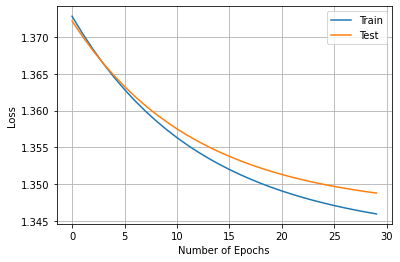

In [34]:
def plot_error_curves(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.grid(True)
    plt.gca()
    plt.ylabel('Loss')
    plt.xlabel('Number of Epochs')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()
    
plot_error_curves(history)

In [36]:
y_pred_color = model.predict(X_test_grayscale)
y_pred_color = y_pred_color.reshape(X_test_grayscale.shape[0] * 32 * 32, 4)
output_images = []
for index in range(len(y_pred_color)):
    output_images.append([int(color) for color in main_colors[np.argmax(y_pred_color[index])]])
    
y_test_new = y_test_grayscale.reshape(X_test_grayscale.shape[0] * 32 * 32, 4)
y_test_k_color = []
for i in range(len(y_test_new)):
    y_test_k_color.append([int(color) for color in main_colors[np.argmax(y_test_new[i])]])
output_images = np.reshape(output_images, (-1, 32, 32, 3))
y_test_k_color = np.reshape(y_test_k_color, (-1, 32, 32, 3))

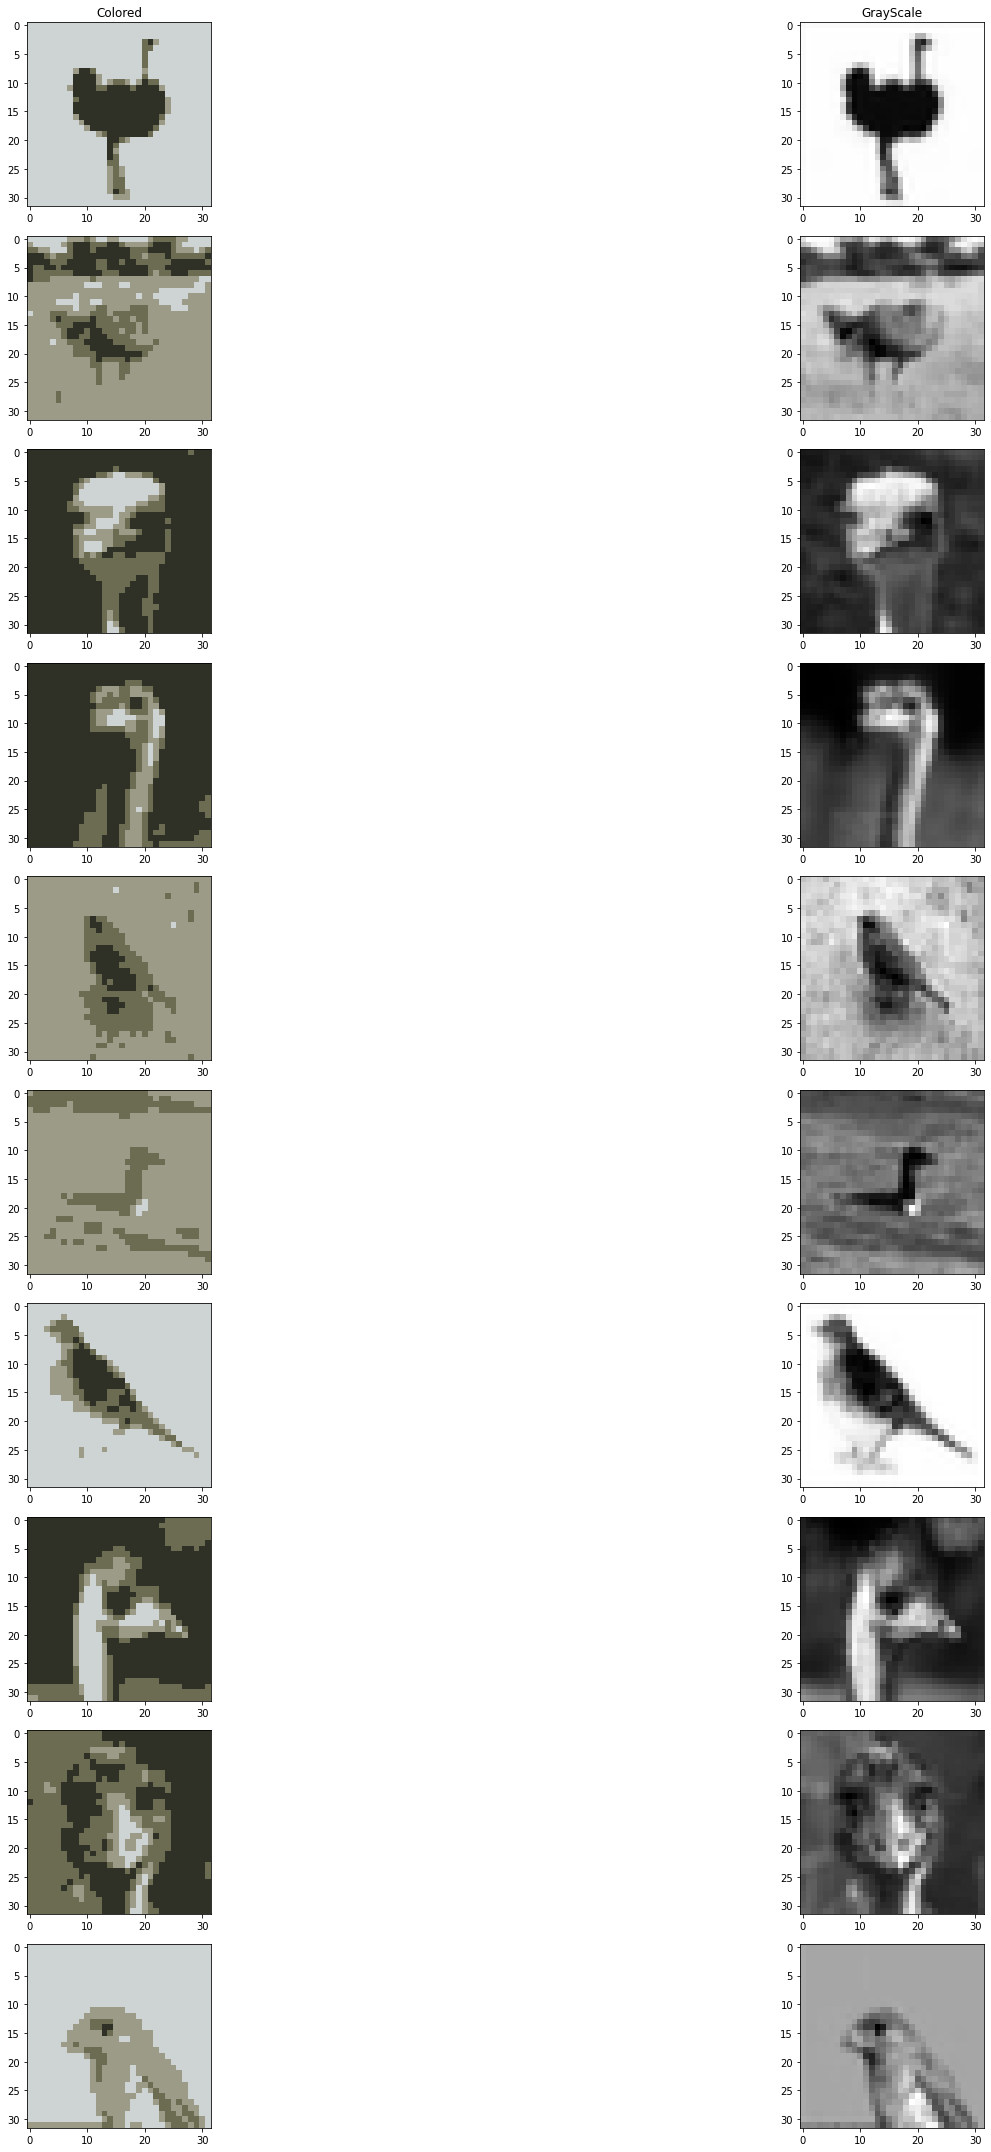

In [43]:
fig, axes = plt.subplots(10, 2, figsize=(30, 30))
ax = axes.ravel()

ax[0].imshow(y_test_k_color[1])
ax[1].imshow(X_test_grayscale.reshape(-1,32,32)[1], cmap=plt.cm.gray)

ax[2].imshow(y_test_k_color[2])
ax[3].imshow(X_test_grayscale.reshape(-1,32,32)[2], cmap=plt.cm.gray)

ax[4].imshow(y_test_k_color[3])
ax[5].imshow(X_test_grayscale.reshape(-1,32,32)[3], cmap=plt.cm.gray)

ax[6].imshow(y_test_k_color[4])
ax[7].imshow(X_test_grayscale.reshape(-1,32,32)[4], cmap=plt.cm.gray)

ax[8].imshow(y_test_k_color[5])
ax[9].imshow(X_test_grayscale.reshape(-1,32,32)[5], cmap=plt.cm.gray)

ax[10].imshow(y_test_k_color[6])
ax[11].imshow(X_test_grayscale.reshape(-1,32,32)[6], cmap=plt.cm.gray)

ax[12].imshow(y_test_k_color[7])
ax[13].imshow(X_test_grayscale.reshape(-1,32,32)[7], cmap=plt.cm.gray)

ax[14].imshow(y_test_k_color[8])
ax[15].imshow(X_test_grayscale.reshape(-1,32,32)[8], cmap=plt.cm.gray)

ax[16].imshow(y_test_k_color[9])
ax[17].imshow(X_test_grayscale.reshape(-1,32,32)[9], cmap=plt.cm.gray)

ax[18].imshow(y_test_k_color[10])
ax[19].imshow(X_test_grayscale.reshape(-1,32,32)[10], cmap=plt.cm.gray)

ax[0].set_title("Colored")
ax[1].set_title("GrayScale")

fig.tight_layout()
plt.show()

## (g) Extra Practice: Repeat the whole exercise with k = 16 colors if your computer can handle the computations.

In [18]:
X_data_new = X_data.reshape(-1, 3)
k_means_clf = KMeans(n_clusters=16, random_state=2333, n_init=10).fit(X_data_new)
main_colors = k_means_clf.cluster_centers_
y_predict = k_means_clf.labels_

-----------------Converted Image-----------------


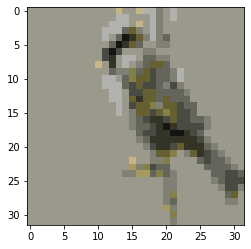

In [19]:
X_converted = np.array([main_colors[y_predict[i]] for i in range(len(X_data_new))], dtype=np.uint8).reshape(-1, 32, 32, 3)

print("-----------------Converted Image-----------------")
plt.imshow(X_converted[81])

-----------------Grayscale Image-----------------


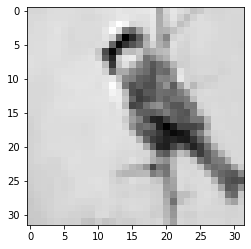

In [20]:
X_grayscale = np.array([rgb2gray(X_data[i]) for i in range(len(X_data))])
print("-----------------Grayscale Image-----------------")
plt.imshow(X_grayscale[81], cmap=plt.cm.gray)

In [55]:
encoder = OneHotEncoder(handle_unknown='ignore')
y_sample = [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15]]
encoder.fit(y_sample)
y_encoded = encoder.transform(y_predict.reshape(-1, 1)).toarray().astype(int).reshape(-1, 32, 32, 16)
X_train_grayscale, X_test_grayscale, y_train_grayscale, y_test_grayscale = train_test_split(X_grayscale.reshape(-1, 32, 32, 1), y_encoded, test_size=0.1, random_state=666)
X_train_grayscale.shape,y_train_grayscale.shape, X_test_grayscale.shape, y_test_grayscale.shape

((5400, 32, 32, 1), (5400, 32, 32, 16), (600, 32, 32, 1), (600, 32, 32, 16))

In [61]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=64, kernel_size=(5,5), strides=(1, 1), padding='same', activation='relu', input_shape=(32,32,1)),
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same'),
    keras.layers.Conv2D(filters=64, kernel_size=(5,5), strides=(1, 1), padding='same', activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same'),
    keras.layers.Dense(32, activation="softmax"),
    keras.layers.Dense(16, activation="softmax")
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 64)        1664      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 64)        102464    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dense_4 (Dense)              (None, 32, 32, 32)        2080      
_________________________________________________________________
dense_5 (Dense)              (None, 32, 32, 16)        528       
Total params: 106,736
Trainable params: 106,736
Non-trainable params: 0
________________________________________________

In [62]:
model.compile(optimizer=keras.optimizers.SGD(0.001), loss='categorical_crossentropy', metrics=["accuracy"])

In [63]:
number_of_epochs = 30
output_directory = "./cnn_checkpoint1"
if not os.path.exists(output_directory):
    os.mkdir(output_directory)
    
checkpoint_prefix = os.path.join(output_directory, 'ck_{epoch:02d}.hdf5')
checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath = checkpoint_prefix,save_weights_only= True)
earlyStoppingCk = keras.callbacks.EarlyStopping(patience = 5, min_delta = 1e-4)

history = model.fit(X_train_grayscale, y_train_grayscale, epochs=number_of_epochs, validation_data=(X_test_grayscale, y_test_grayscale), callbacks=[checkpoint_callback, earlyStoppingCk])

Epoch 1/30
169/169 [==============================] - 107s 635ms/step - loss: 2.7732 - accuracy: 0.0968 - val_loss: 2.7721 - val_accuracy: 0.0955
Epoch 2/30
169/169 [==============================] - 107s 635ms/step - loss: 2.7713 - accuracy: 0.0968 - val_loss: 2.7702 - val_accuracy: 0.0955
Epoch 3/30
169/169 [==============================] - 107s 635ms/step - loss: 2.7695 - accuracy: 0.0968 - val_loss: 2.7684 - val_accuracy: 0.0955
Epoch 4/30
169/169 [==============================] - 108s 640ms/step - loss: 2.7677 - accuracy: 0.0968 - val_loss: 2.7666 - val_accuracy: 0.0955
Epoch 5/30
169/169 [==============================] - 107s 634ms/step - loss: 2.7659 - accuracy: 0.0968 - val_loss: 2.7649 - val_accuracy: 0.0955
Epoch 6/30
169/169 [==============================] - 109s 647ms/step - loss: 2.7642 - accuracy: 0.0968 - val_loss: 2.7632 - val_accuracy: 0.0955
Epoch 7/30
169/169 [==============================] - 108s 638ms/step - loss: 2.7625 - accuracy: 0.0968 - val_loss: 2.7615 -

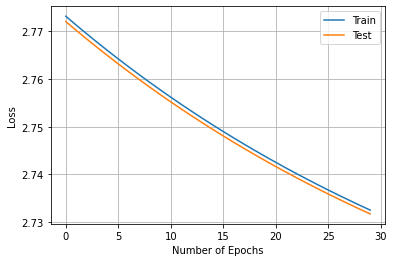

In [64]:
def plot_error_curves(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.grid(True)
    plt.gca()
    plt.ylabel('Loss')
    plt.xlabel('Number of Epochs')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()
    
plot_error_curves(history)

In [65]:
y_pred_color = model.predict(X_test_grayscale)
y_pred_color = y_pred_color.reshape(X_test_grayscale.shape[0] * 32 * 32, 16)
output_images = []
for index in range(len(y_pred_color)):
    output_images.append([int(color) for color in main_colors[np.argmax(y_pred_color[index])]])
    
y_test_new = y_test_grayscale.reshape(X_test_grayscale.shape[0] * 32 * 32, 16)
y_test_k_color = []
for i in range(len(y_test_new)):
    y_test_k_color.append([int(color) for color in main_colors[np.argmax(y_test_new[i])]])
output_images = np.reshape(output_images, (-1, 32, 32, 3))
y_test_k_color = np.reshape(y_test_k_color, (-1, 32, 32, 3))

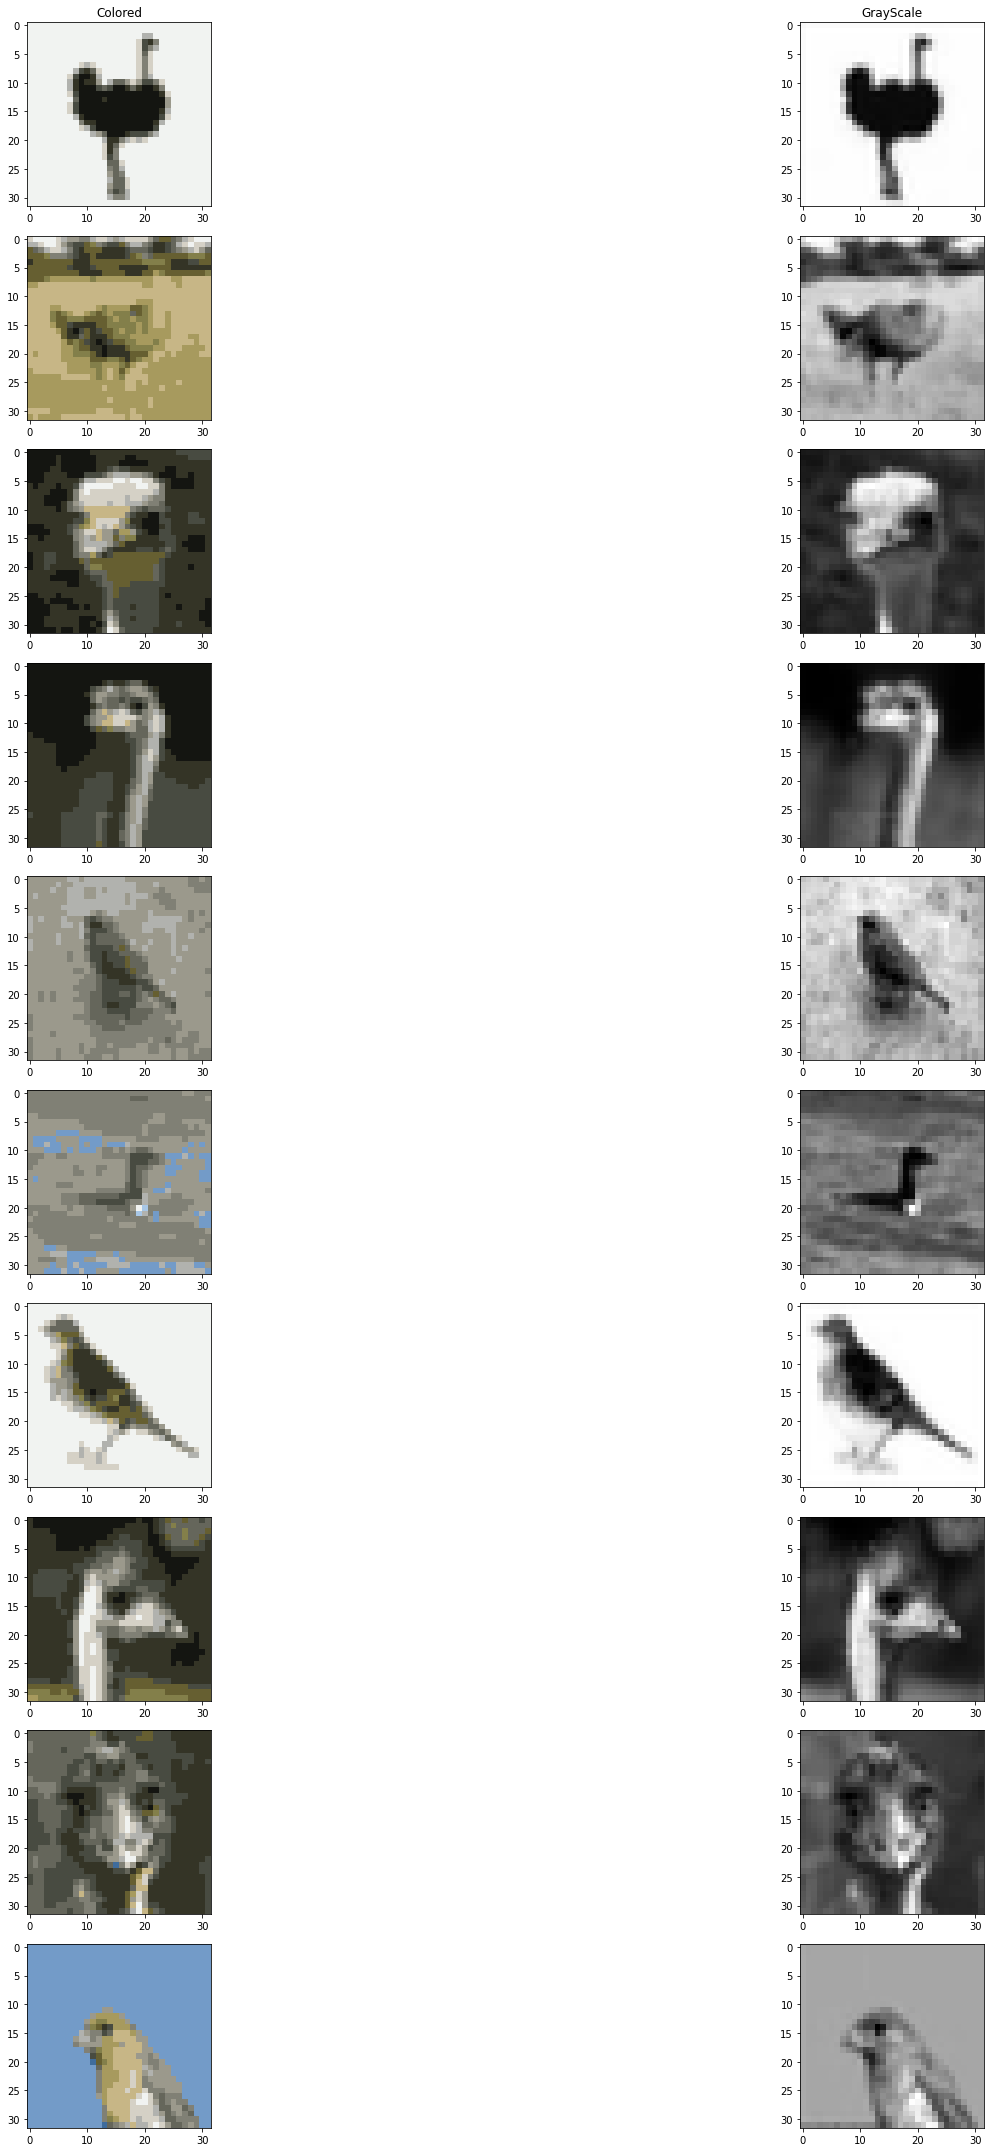

In [66]:
fig, axes = plt.subplots(10, 2, figsize=(30, 30))
ax = axes.ravel()

ax[0].imshow(y_test_k_color[1])
ax[1].imshow(X_test_grayscale.reshape(-1,32,32)[1], cmap=plt.cm.gray)

ax[2].imshow(y_test_k_color[2])
ax[3].imshow(X_test_grayscale.reshape(-1,32,32)[2], cmap=plt.cm.gray)

ax[4].imshow(y_test_k_color[3])
ax[5].imshow(X_test_grayscale.reshape(-1,32,32)[3], cmap=plt.cm.gray)

ax[6].imshow(y_test_k_color[4])
ax[7].imshow(X_test_grayscale.reshape(-1,32,32)[4], cmap=plt.cm.gray)

ax[8].imshow(y_test_k_color[5])
ax[9].imshow(X_test_grayscale.reshape(-1,32,32)[5], cmap=plt.cm.gray)

ax[10].imshow(y_test_k_color[6])
ax[11].imshow(X_test_grayscale.reshape(-1,32,32)[6], cmap=plt.cm.gray)

ax[12].imshow(y_test_k_color[7])
ax[13].imshow(X_test_grayscale.reshape(-1,32,32)[7], cmap=plt.cm.gray)

ax[14].imshow(y_test_k_color[8])
ax[15].imshow(X_test_grayscale.reshape(-1,32,32)[8], cmap=plt.cm.gray)

ax[16].imshow(y_test_k_color[9])
ax[17].imshow(X_test_grayscale.reshape(-1,32,32)[9], cmap=plt.cm.gray)

ax[18].imshow(y_test_k_color[10])
ax[19].imshow(X_test_grayscale.reshape(-1,32,32)[10], cmap=plt.cm.gray)

ax[0].set_title("Colored")
ax[1].set_title("GrayScale")

fig.tight_layout()
plt.show()